# Mixed Layer Heat Budget

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram

In [2]:
#GLORYS vars
thetao = xr.open_dataset('sst_glorys.nc', chunks={})
uv = xr.open_dataset('glorys_uv.nc', chunks={})
mld = xr.open_dataset('glorys_mld.nc', chunks={})
glorys = xr.merge([thetao, uv, mld])

#ERA5 vars
sst_ds1 = xr.open_dataset('/work5/stb/ERA5/sst.nc', chunks={})
sst_ds = sst_ds1.assign_coords({'longitude':(sst_ds1.longitude.values-360)})
#mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc', chunks={})
heat_fluxes_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/era-heat-fluxes.nc', chunks={})
heat_fluxes_unprocessed = heat_fluxes_ds.assign_coords({'longitude':(heat_fluxes_ds.longitude.values-360)})

#Sliced sst,u,v to MLD
mlt = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/mlt.nc', chunks={})
mlu = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/mlu.nc', chunks={})
mlv = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/mlv.nc', chunks={})
ggom_mld = xr.merge([mlt, mlu, mlv])

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [4]:
ggom_mld

<xarray.Dataset> Size: 25GB
Dimensions:    (depth: 3, latitude: 163, longitude: 205, time: 10408)
Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>

In [4]:
glorys

<xarray.Dataset> Size: 702GB
Dimensions:    (depth: 49, latitude: 169, longitude: 337, time: 10408)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 676B 17.0 17.08 17.17 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 1kB -100.0 -99.92 -99.83 ... -72.08 -72.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 232GB dask.array<chunksize=(10408, 49, 169, 337), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 232GB dask.array<chunksize=(10408, 49, 169, 337), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 232GB dask.array<chunksize=(10408, 49, 169, 337), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float64 5GB dask.array<chunksize=(10408, 169, 337), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

In [5]:
heat_fluxes_unprocessed

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

# 1) Process budget variables 
(to desired spatial/grid and temporal configuration)

In [5]:
time_slice = dict(time=slice('1993', '2021-06-30'))
gom = dict(longitude=slice(-98, -81), latitude=slice(31, 17.5))
gom_g = dict(longitude=slice(-98, -81), latitude=slice(17.5, 31))
se = dict(longitude=slice(-90, -85), latitude=slice(31, 28))
se_g = dict(longitude=slice(-90, -85), latitude=slice(28,31))

In [6]:
sst = sst_ds.sea_surface_temperature.sel(**gom).sel(**time_slice).resample(time='D').mean()
#mask = mask_ds.land_sea_mask
sw = heat_fluxes_unprocessed.ssr.sel(**gom).sel(**time_slice) / (60*60) #W/m2
lw = heat_fluxes_unprocessed.str.sel(**gom).sel(**time_slice) / (60*60) #W/m2
sh = heat_fluxes_unprocessed.sshf.sel(**gom).sel(**time_slice) / (60*60) #W/m2
lh = heat_fluxes_unprocessed.slhf.sel(**gom).sel(**time_slice) / (60*60) #W/m2

ggom = glorys.sel(**time_slice).sel(**gom_g)
heat_fluxes = xr.merge([sw,lw,sh,lh])
era5 = xr.merge([sst,sw,lw,sh,lh])

In [8]:
era5

<xarray.Dataset> Size: 1GB
Dimensions:                  (latitude: 55, longitude: 69, time: 10408)
Coordinates:
  * latitude                 (latitude) float32 220B 31.0 30.75 ... 17.75 17.5
  * longitude                (longitude) float32 276B -98.0 -97.75 ... -81.0
  * time                     (time) datetime64[ns] 83kB 1993-01-01 ... 2021-0...
Data variables:
    sea_surface_temperature  (time, latitude, longitude) float32 158MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    ssr                      (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str                      (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf                     (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf                     (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>

In [9]:
ggom

<xarray.Dataset> Size: 412GB
Dimensions:    (depth: 49, latitude: 163, longitude: 205, time: 10408)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 136GB dask.array<chunksize=(10408, 49, 163, 205), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 136GB dask.array<chunksize=(10408, 49, 163, 205), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 136GB dask.array<chunksize=(10408, 49, 163, 205), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float64 3GB dask.array<chunksize=(10408, 163, 205), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

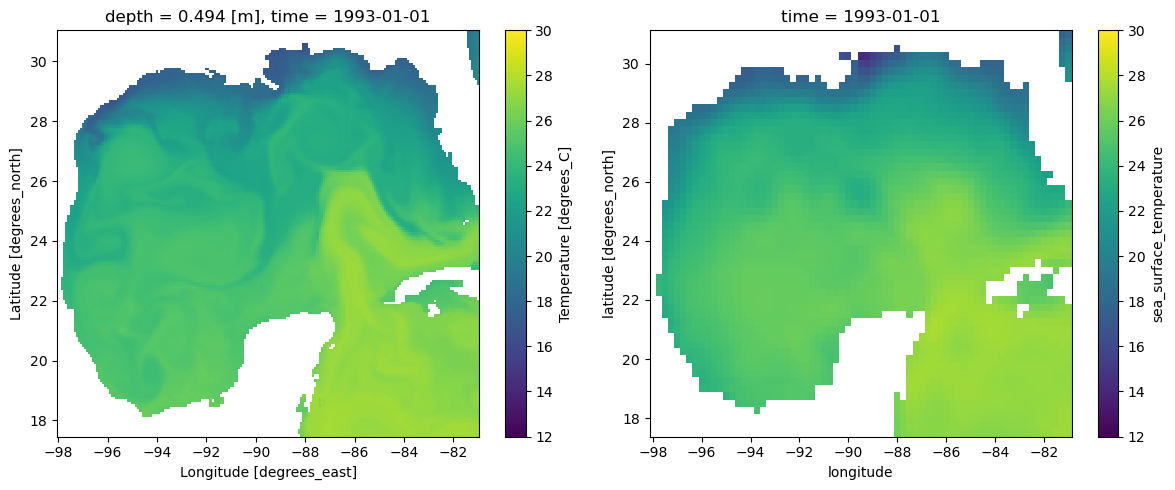

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
ggom.thetao[0,0].plot(ax=ax0, vmin=12, vmax=30)
era5.sea_surface_temperature[0].plot(ax=ax1, vmin=12, vmax=30)
plt.tight_layout();

#### Mask to MLD

In [9]:
t = ggom.uo.isel(time=0).where(ggom.depth<=ggom.mlotst.isel(time=0))

In [10]:
t

<xarray.DataArray 'uo' (depth: 49, latitude: 163, longitude: 205)> Size: 13MB
dask.array<where, shape=(49, 163, 205), dtype=float64, chunksize=(49, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
    time       datetime64[ns] 8B 1993-01-01
Attributes:
    standard_name:  eastward_sea_water_velocity
    unit_long:      Meters per second
    valid_min:      -3123
    units:          m s-1
    valid_max:      4314
    long_name:      Eastward velocity

In [14]:
t450 = t.isel(depth=30).load()

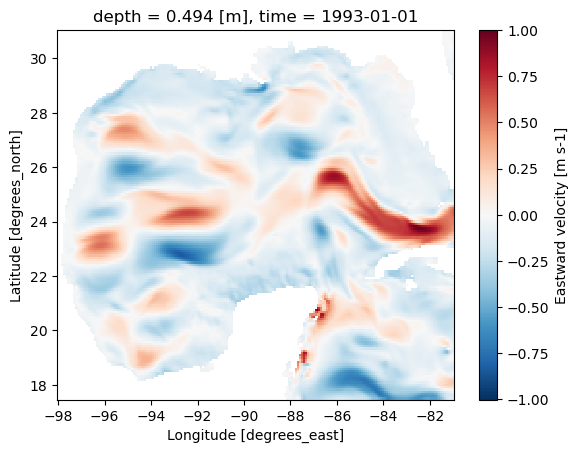

In [15]:
t1.plot()

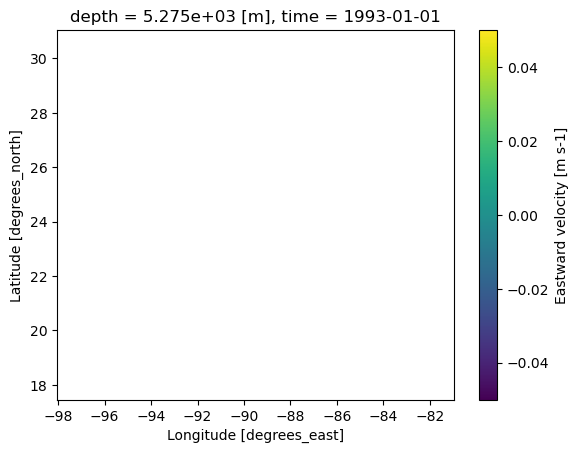

In [12]:
t49.plot()

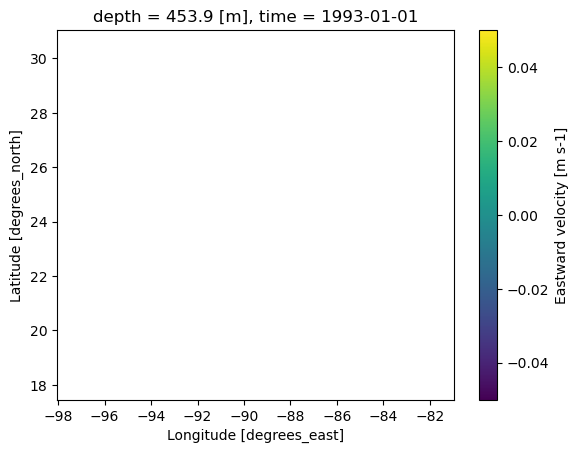

In [15]:
t450.plot()

In [10]:
mlt_list = []
mlu_list = []
mlv_list = []

for i in ggom.time:
    mlt_list.append(ggom.thetao.sel(time=i).where(ggom.depth<=ggom.mlotst.sel(time=i)))
    mlu_list.append(ggom.uo.sel(time=i).where(ggom.depth<=ggom.mlotst.sel(time=i)))
    mlv_list.append(ggom.vo.sel(time=i).where(ggom.depth<=ggom.mlotst.sel(time=i)))

In [11]:
mlt = xr.concat(mlt_list, dim='time')
mlu = xr.concat(mlu_list, dim='time')
mlv = xr.concat(mlv_list, dim='time')

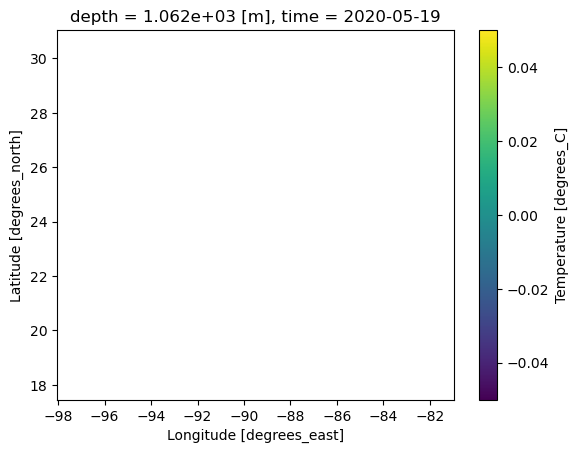

In [30]:
mlt.sel(depth=1.062440e+03).isel(time=10000).plot()

In [40]:
ggom.mlotst.max().values

array(204.01624562)

In [35]:
mlt.depth

<xarray.DataArray 'depth' (depth: 49)> Size: 196B
array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
       6.440614e+00, 7.929560e+00, 9.572997e+00, 1.140500e+01, 1.346714e+01,
       1.581007e+01, 1.849556e+01, 2.159882e+01, 2.521141e+01, 2.944473e+01,
       3.443415e+01, 4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02, 1.558507e+02,
       1.861256e+02, 2.224752e+02, 2.660403e+02, 3.181274e+02, 3.802130e+02,
       4.539377e+02, 5.410889e+02, 6.435668e+02, 7.633331e+02, 9.023393e+02,
       1.062440e+03, 1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03, 3.597032e+03,
       3.992484e+03, 4.405224e+03, 4.833291e+03, 5.274784e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Attributes:
    long_name:      Depth
    unit_long:      Meters
    standard_name:  depth
    positive:       down
    units:          m
    axis:           Z

In [12]:
mlt_sliced = mlt.sel(depth=slice(0, 2.645669e+00))
mlu_sliced = mlu.sel(depth=slice(0, 2.645669e+00))
mlv_sliced = mlv.sel(depth=slice(0, 2.645669e+00))

In [13]:
mlt_sliced

<xarray.DataArray 'thetao' (time: 10408, depth: 3, latitude: 163, longitude: 205)> Size: 8GB
dask.array<getitem, shape=(10408, 3, 163, 205), dtype=float64, chunksize=(1, 3, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Attributes:
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_min:      -32766
    valid_max:      21306
    units:          degrees_C

In [14]:
mlt_sliced.isel(time=0).isel(depth=-1)#.plot()

<xarray.DataArray 'thetao' (latitude: 163, longitude: 205)> Size: 267kB
dask.array<getitem, shape=(163, 205), dtype=float64, chunksize=(163, 205), chunktype=numpy.ndarray>
Coordinates:
    depth      float32 4B 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
    time       datetime64[ns] 8B 1993-01-01
Attributes:
    long_name:      Temperature
    unit_long:      Degrees Celsius
    standard_name:  sea_water_potential_temperature
    valid_min:      -32766
    valid_max:      21306
    units:          degrees_C

# 2) UNWEIGHTED Compute each term in the budget equation below

## 2a) UNWEIGHTED $\frac{\partial \theta}{\partial t}$

In [5]:
dθ = mlt.thetao.diff('time')
dt_values = (np.diff(mlt.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], mlt.time.values[1:])})

dθdt = dθ / dt #˚C/s

In [6]:
dθdt

<xarray.DataArray (time: 10407, depth: 3, latitude: 163, longitude: 205)> Size: 8GB
dask.array<truediv, shape=(10407, 3, 163, 205), dtype=float64, chunksize=(10407, 3, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30

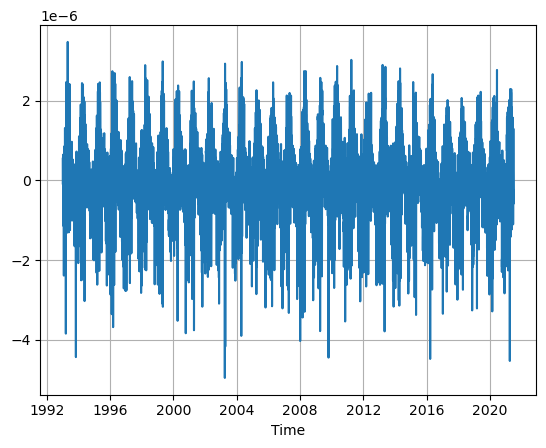

In [7]:
dθdt.mean(['depth', 'latitude', 'longitude']).plot()
plt.grid();

## 2b) UNWEIGHTED $-\frac{1}{H}\int^{0}_{-H}(\mathbf{u} \cdot \nabla\theta)dz$

### Create grid and area objects

In [9]:
ds_pt_full = generate_grid_ds(ggom_mld, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [10]:
ds_pt_full

<xarray.Dataset> Size: 25GB
Dimensions:         (depth: 3, latitude: 163, longitude: 205, time: 10408,
                     longitude_left: 205, latitude_left: 163)
Coordinates:
  * depth           (depth) float32 12B 0.494 1.541 2.646
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * longitude       (longitude) float32 820B -98.0 -97.92 ... -81.08 -81.0
  * time            (time) datetime64[ns] 83kB 1993-01-01 ... 2021-06-30
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04
  * latitude_left   (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96
Data variables:
    thetao          (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    uo              (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    vo              (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>

In [11]:
grid_pt_full

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   depth

In [12]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [13]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


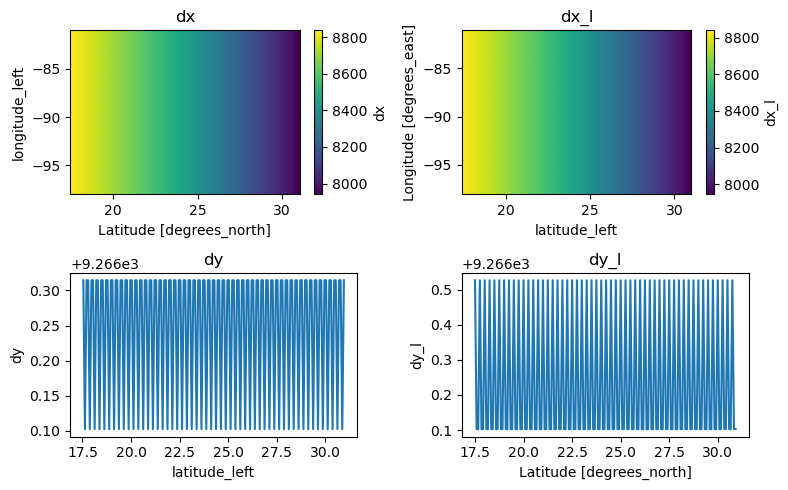

In [14]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [15]:
ggom_mld

<xarray.Dataset> Size: 25GB
Dimensions:    (depth: 3, latitude: 163, longitude: 205, time: 10408)
Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 8GB dask.array<chunksize=(10408, 3, 163, 205), meta=np.ndarray>

In [16]:
dθdx = (grid_pt_full.diff(ggom_mld.thetao, 'X') / cell_elements_glorys.dx)
dθdy = (grid_pt_full.diff(ggom_mld.thetao, 'Y') / cell_elements_glorys.dy) 

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [17]:
dθdx.coords

Coordinates:
  * depth           (depth) float32 12B 0.494 1.541 2.646
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * time            (time) datetime64[ns] 83kB 1993-01-01 ... 2021-06-30
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04

In [18]:
dθdy.coords

Coordinates:
  * depth          (depth) float32 12B 0.494 1.541 2.646
  * longitude      (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time           (time) datetime64[ns] 83kB 1993-01-01 ... 2021-06-30
  * latitude_left  (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96

In [19]:
dθdx_interp = grid_pt_full.interp(dθdx, 'X')
dθdy_interp = grid_pt_full.interp(dθdy, 'Y')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [20]:
ggom_mld.vo.coords

Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [21]:
dθdy_interp.isel(depth=slice(1,None)).coords

Coordinates:
  * depth      (depth) float32 8B 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [22]:
udθdx = ggom_mld.uo * dθdx_interp.isel(depth=slice(1,None))
vdθdy = ggom_mld.vo * dθdy_interp.isel(depth=slice(1,None))

In [23]:
udθdx

<xarray.DataArray (time: 10408, depth: 2, latitude: 163, longitude: 205)> Size: 6GB
dask.array<mul, shape=(10408, 2, 163, 205), dtype=float64, chunksize=(10408, 2, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 8B 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

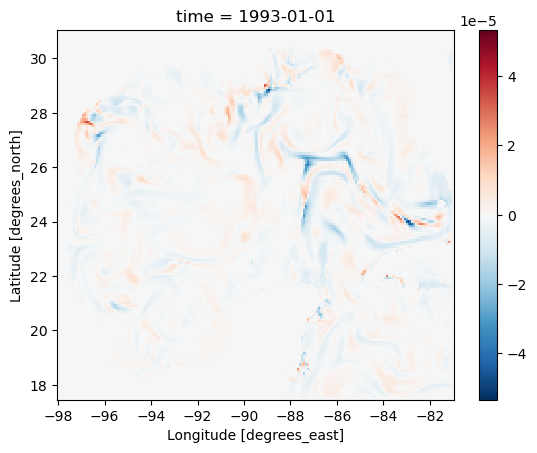

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [24]:
(udθdx + vdθdy).sum('depth')[0].plot()

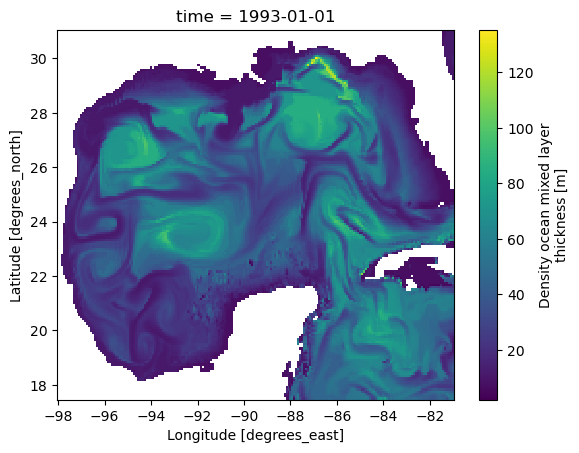

In [26]:
ggom.mlotst[0].plot()

In [27]:
ggom.mlotst.coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [28]:
(udθdx + vdθdy).sum('depth').coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [30]:
second_term = (-1 / ggom.mlotst) * (udθdx + vdθdy).sum('depth')

In [31]:
second_term

<xarray.DataArray (time: 10408, latitude: 163, longitude: 205)> Size: 3GB
dask.array<mul, shape=(10408, 163, 205), dtype=float64, chunksize=(10408, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [32]:
second_term.chunk({'time':1301.0, 'longitude':-1, 'latitude':-1})

<xarray.DataArray (time: 10408, latitude: 163, longitude: 205)> Size: 3GB
dask.array<rechunk-merge, shape=(10408, 163, 205), dtype=float64, chunksize=(1301, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

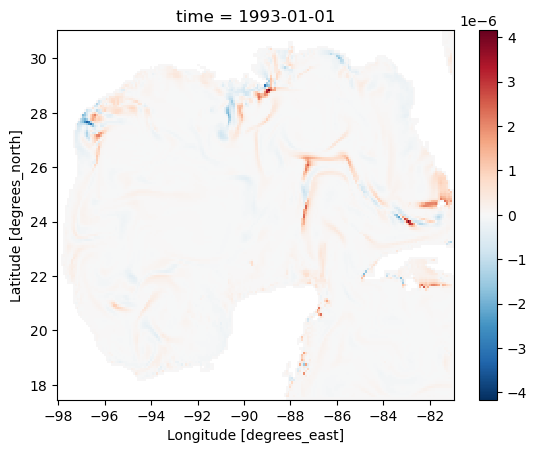

In [33]:
second_term.isel(time=0).plot()

In [34]:
scnd_trm_2save = second_term.rename('advection').chunk({'time':1301.0, 'longitude':-1, 'latitude':-1})

In [35]:
scnd_trm_2save

<xarray.DataArray 'advection' (time: 10408, latitude: 163, longitude: 205)> Size: 3GB
dask.array<rechunk-merge, shape=(10408, 163, 205), dtype=float64, chunksize=(1301, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [36]:
scnd_trm_2save.to_netcdf('/work5/stb/MHW-gfdl/MLHB-terms/adv_9321_unweighted_mld.nc')

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)
/home/Shanice.Bailey/.local/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [38]:
t = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/dTdt_9321_unweighted_mld.nc', chunks={})

In [40]:
dθdt = t.tendency

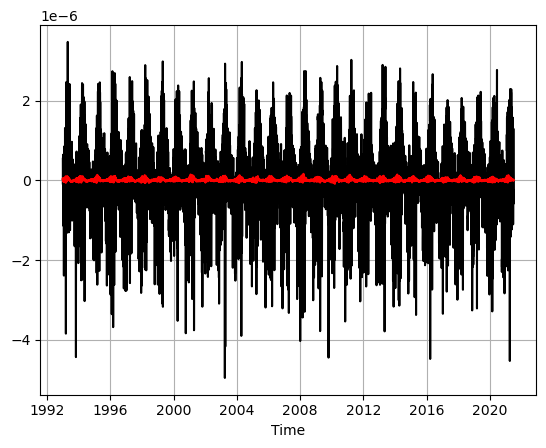

In [41]:
dθdt.mean(['depth', 'latitude', 'longitude']).plot(color='k')
second_term.mean(['latitude', 'longitude']).plot(color='r')
plt.grid();

## 2c) UNWEIGHTED $\frac{Q}{\rho C_p H} $

### Create grid and area objects

In [42]:
ds_full_e = generate_grid_ds(heat_fluxes, {'X':'longitude', 'Y':'latitude'})
#ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

grid_e = xgcm.Grid(ds_full_e, periodic='X')
#grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [43]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [44]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
#cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


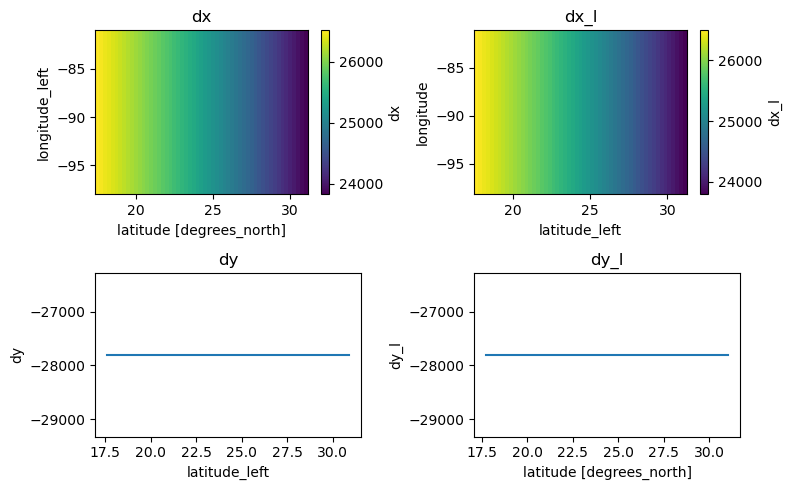

In [45]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [46]:
#Create decay function for SSR penetration
#Jerlov Type 1 (upper 50m)
R = 0.68
h1 = 1.2 #m
h2 = 28 #m
z_values = np.array([0, 4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03])
z = xr.DataArray(data=z_values, dims={'depth'}, coords={'depth':z_values})
F_ps77 = R * np.exp(-z/h1) + (1-R) * np.exp(-z/h2)

#expand ssr da in z dimension then apply decay function 
ssr_Zexpanded = heat_fluxes.ssr.expand_dims({'depth':z}) 
ssr_z = ssr_Zexpanded * (F_ps77)

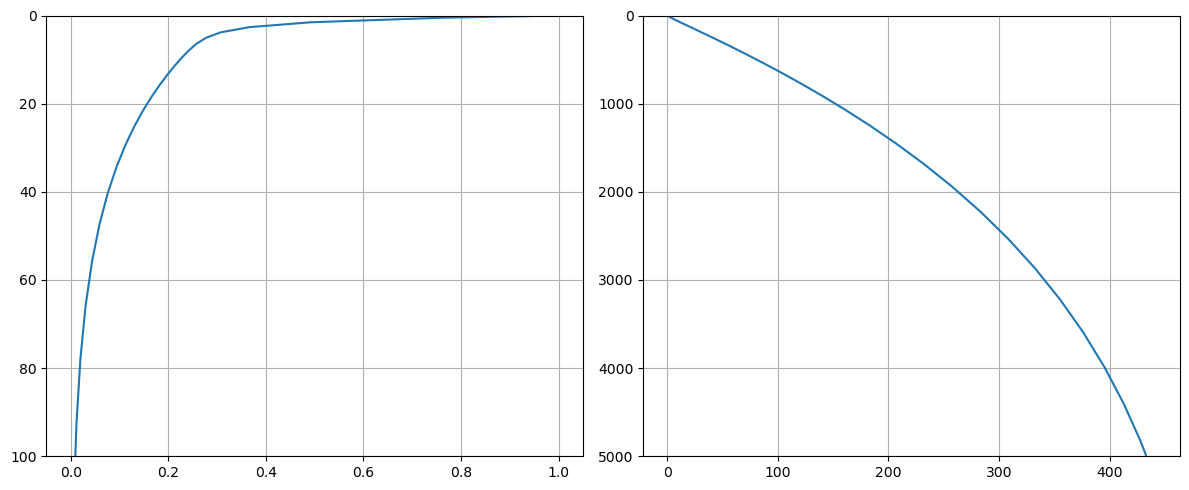

In [47]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(F_ps77, z)
ax0.set_ylim(100, 0)
ax0.grid()

ax1.plot(z.diff(dim='depth'), z.diff(dim='depth').depth)
ax1.set_ylim(5000,0)
#ax1.set_xlim(0, None)
ax1.grid()

plt.tight_layout();

In [48]:
ssr_z

<xarray.DataArray (depth: 50, time: 10408, latitude: 55, longitude: 69)> Size: 16GB
dask.array<mul, shape=(50, 10408, 55, 69), dtype=float64, chunksize=(50, 10408, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 400B 0.0 0.494 1.541 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

In [66]:
ssrz_list = []
for i in ggom.time:
    ssrz_list.append(ssr_z.sel(time=i).where(ggom.depth<=ggom.mlotst.sel(time=i)))

In [67]:
mlssrz = xr.concat(ssrz_list, dim='time')

In [68]:
mlssrz

<xarray.DataArray (time: 10408, depth: 0, latitude: 55, longitude: 69)> Size: 0B
dask.array<concatenate, shape=(10408, 0, 55, 69), dtype=float64, chunksize=(1, 0, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 0B 
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

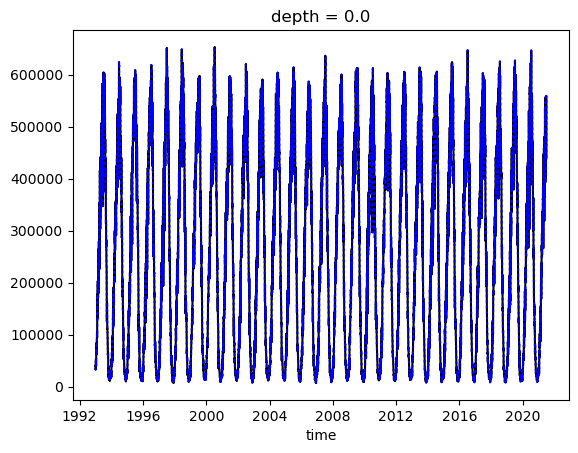

In [61]:
heat_fluxes.ssr.sum(['latitude', 'longitude']).plot(color='k')
ssr_z.sum(['latitude', 'longitude']).isel(depth=0).plot(color='blue', linestyle='dotted')
#mlssrz.drop_vars('depth').sum(['latitude', 'longitude']).plot(color='r', linestyle='-.')

In [69]:
dFlx = ssr_z.diff(dim='depth')
dz = z.diff(dim='depth')
dFlxdz = - dFlx / dz

In [70]:
dFlxdz

<xarray.DataArray (depth: 49, time: 10408, latitude: 55, longitude: 69)> Size: 15GB
dask.array<truediv, shape=(49, 10408, 55, 69), dtype=float64, chunksize=(49, 10408, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

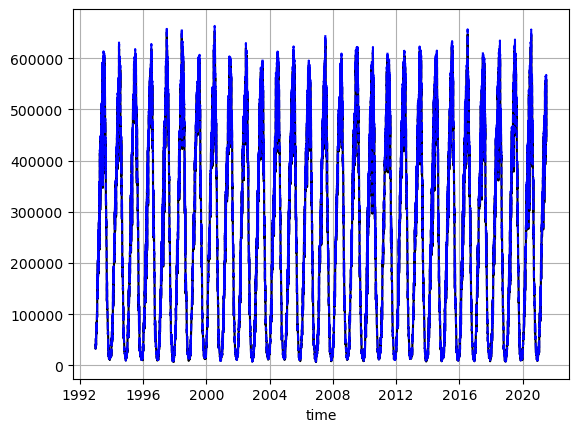

In [71]:
heat_fluxes.ssr.sum(['latitude', 'longitude']).plot(color='k')
dFlxdz.sum(['latitude', 'longitude', 'depth']).plot(color='blue', linestyle='--')
plt.grid()

In [72]:
heat_fluxes['ssr_z'] = dFlxdz

In [73]:
heat_fluxes

<xarray.Dataset> Size: 17GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69, depth: 49)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Data variables:
    ssr        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    ssr_z      (depth, time, latitude, longitude) float64 15GB dask.array<chunksize=(49, 10408, 55, 69), meta=np.ndarray>

In [74]:
heat_fluxes.ssr_z.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03

In [75]:
ggom.mlotst.coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [76]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027
sw = heat_fluxes.ssr_z * (1 / rho) * (1 / Cp) * (1 / ggom.mlotst)
lw = heat_fluxes.str * (1 / rho) * (1 / Cp) * (1 / ggom.mlotst)
sh = heat_fluxes.sshf * (1 / rho) * (1 / Cp) * (1 / ggom.mlotst)
lh = heat_fluxes.slhf * (1 / rho) * (1 / Cp) * (1 / ggom.mlotst)

third_term = xr.merge([sw.rename('sw'), lw.rename('lw'), sh.rename('sh'), lh.rename('lh')])

In [77]:
third_term

<xarray.Dataset> Size: 16GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69, depth: 49)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Data variables:
    sw         (depth, time, latitude, longitude) float64 15GB dask.array<chunksize=(49, 10408, 55, 69), meta=np.ndarray>
    lw         (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    sh         (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>
    lh         (time, latitude, longitude) float64 316MB dask.array<chunksize=(10408, 55, 69), meta=np.ndarray>

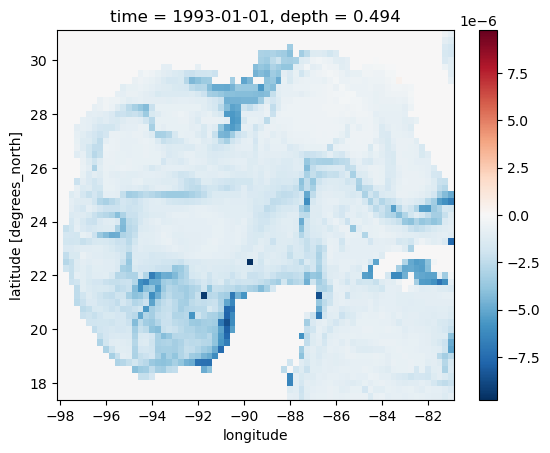

In [78]:
third_term.to_array().sum('variable')[0,0].plot()

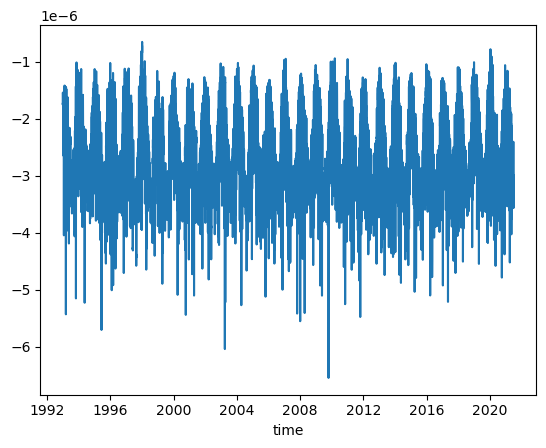

In [79]:
third_term.mean(['depth', 'longitude', 'latitude']).to_array().sum('variable').plot()

In [80]:
third_term.to_netcdf('/work5/stb/MHW-gfdl/MLHB-terms/surf_fluxes_9321_unweighted_mld.nc')

# 2) Compute each term in the budget equation below

$$ \frac{\partial \theta}{\partial t} =  -\frac{1}{H}\int^{0}_{-H}(\mathbf{u} \cdot \nabla\theta)dz + \frac{Q}{\rho C_p H} + residual$$

- 1st term: temperature tendency
- 2nd term: vertical integral of the product between the depth-dependent $\mathbf{u}$ and the horizontal gradient of the mixed layer temperature T
- 3rd term: air-sea heat flux Q, where ρ is the average seawater density, Cp is the specific heat capacity of seawater (4000 J kg−1 °C−1), H is the mixed layer depth
- 4th term: the residual includes horizontal eddy heat fluxes and the heat flux at the bottom of the mixed layer owing to radiative heat loss, vertical diffusion, entrainment, and vertical advection
([Amaya 2020](https://www.nature.com/articles/s41467-019-10206-z))

## 2a) $\frac{\partial \theta}{\partial t}$

### Create grid and area objects

In [10]:
ds_pt_full = generate_grid_ds(ggom, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [11]:
ds_pt_full

<xarray.Dataset> Size: 29GB
Dimensions:         (depth: 49, latitude: 163, longitude: 205, time: 730,
                     longitude_left: 205, latitude_left: 163)
Coordinates:
  * depth           (depth) float32 196B 0.494 1.541 ... 4.833e+03 5.275e+03
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * longitude       (longitude) float32 820B -98.0 -97.92 ... -81.08 -81.0
  * time            (time) datetime64[ns] 6kB 1993-01-01 ... 1994-12-31
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04
  * latitude_left   (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96
Data variables:
    thetao          (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    uo              (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    vo              (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    mlotst          (time, latitude, longitude) float64 195MB dask.array<chunksize=(730, 163, 205), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

In [12]:
grid_pt_full

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
Z Axis (not periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time

In [13]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [14]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


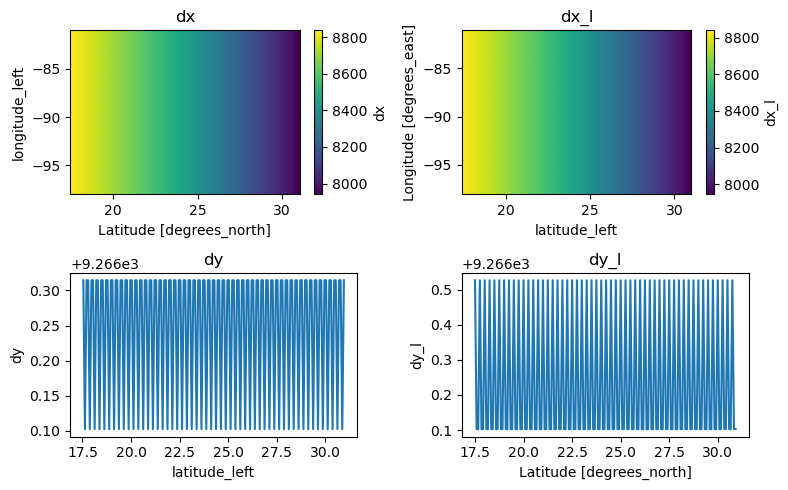

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [16]:
#Volume weighted step
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')
dz = ggom.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
theta_weighted = ggom.thetao.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol
u_weighted = ggom.uo.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol
v_weighted = ggom.vo.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol

In [17]:
theta_weighted

<xarray.DataArray (time: 730, depth: 48, latitude: 163, longitude: 204)> Size: 9GB
dask.array<mul, shape=(730, 48, 163, 204), dtype=float64, chunksize=(730, 48, 163, 204), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 192B 1.541 2.646 3.819 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

In [18]:
dt_values = (np.diff(theta_weighted.time)/1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], coords={'time':(['time'], theta_weighted.time.values[1:])})

dθdt = theta_weighted.diff('time', label='upper') / dt #m^3/s

In [19]:
dθdt

<xarray.DataArray (time: 729, depth: 48, latitude: 163, longitude: 204)> Size: 9GB
dask.array<truediv, shape=(729, 48, 163, 204), dtype=float64, chunksize=(729, 48, 163, 204), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 192B 1.541 2.646 3.819 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-02 1993-01-03 ... 1994-12-31

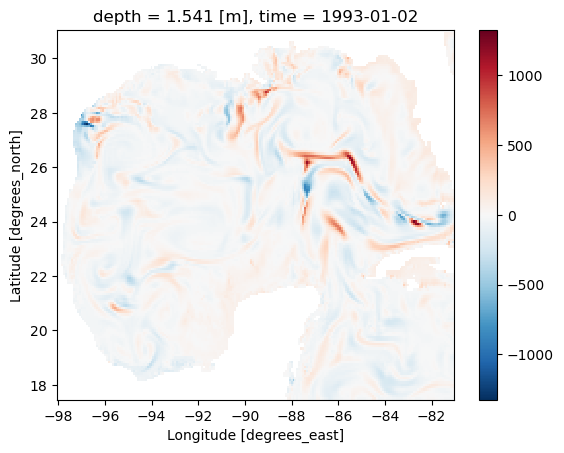

In [18]:
dθdt[0,0].plot()

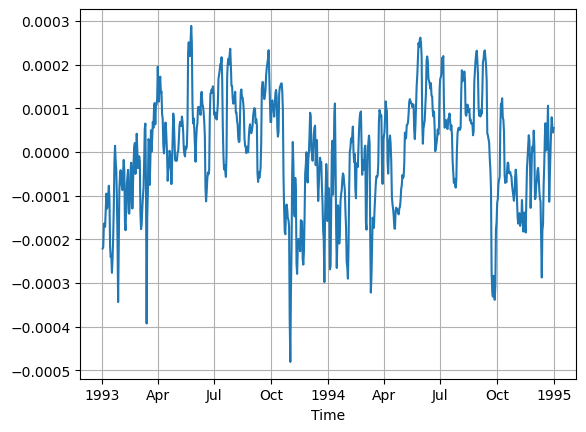

In [23]:
(dθdt.mean(['depth', 'latitude', 'longitude'])/1e6).plot()
plt.grid();

## 2b) $-\frac{1}{H}\int^{0}_{-H}(\mathbf{u} \cdot \nabla\theta)dz$

### Create grid and area objects

In [12]:
ds_pt_full = generate_grid_ds(ggom, {'X':'longitude', 'Y':'latitude'})
grid_pt_full = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [13]:
ds_pt_full

<xarray.Dataset> Size: 29GB
Dimensions:         (depth: 49, latitude: 163, longitude: 205, time: 730,
                     longitude_left: 205, latitude_left: 163)
Coordinates:
  * depth           (depth) float32 196B 0.494 1.541 ... 4.833e+03 5.275e+03
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * longitude       (longitude) float32 820B -98.0 -97.92 ... -81.08 -81.0
  * time            (time) datetime64[ns] 6kB 1993-01-01 ... 1994-12-31
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04
  * latitude_left   (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96
Data variables:
    thetao          (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    uo              (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    vo              (time, depth, latitude, longitude) float64 10GB dask.array<chunksize=(730, 49, 163, 205), meta=np.ndarray>
    mlotst          (time, latitude, longitude) float64 195MB dask.array<chunksize=(730, 163, 205), meta=np.ndarray>
Attributes:
    comment:      CMEMS product
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...
    source:       MERCATOR GLORYS12V1
    Conventions:  CF-1.4
    history:      2023/06/01 16:20:05 MERCATOR OCEAN Netcdf creation
    references:   http://www.mercator-ocean.fr
    institution:  MERCATOR OCEAN

In [14]:
grid_pt_full

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center

In [15]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [16]:
cell_elements_glorys = deg_2_m(grid_pt_full, ds_pt_full, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


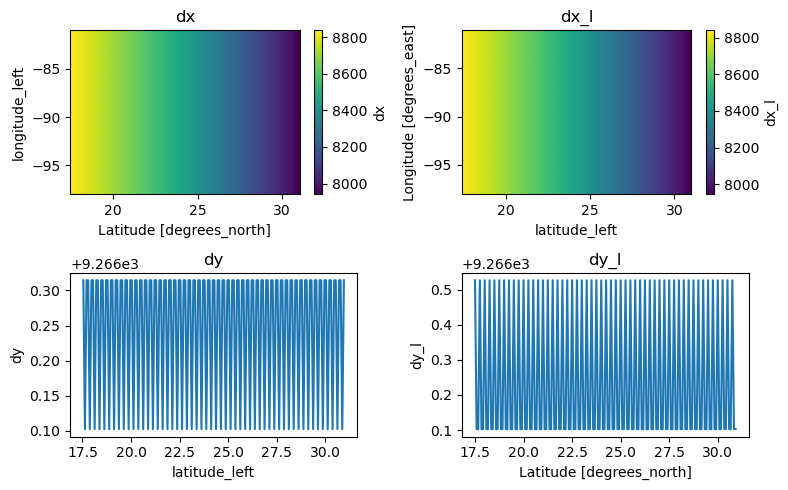

In [17]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_glorys.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_glorys.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_glorys.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_glorys.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [16]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')
dz = ggom.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz
theta_weighted = ggom.thetao.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol
u_weighted = ggom.uo.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol
v_weighted = ggom.vo.isel(depth=slice(1,None), longitude=slice(None,-1)) * vol

In [24]:
dx_interp = grid_pt_full.interp(cell_elements_glorys.dx_l, 'Y')
dz = ggom.depth.diff(dim='depth', label='upper')
vol = cell_elements_glorys.dy_l * dx_interp[:-1,:] * dz

u_weighted = ggom.uo.isel(depth=slice(1,None), longitude=slice(None, -1)) * dz * cell_elements_glorys.dy_l 
v_weighted = ggom.vo.isel(depth=slice(1,None), longitude=slice(None, -1)) * dz * dx_interp.isel(longitude=slice(None, -1))

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [25]:
v_weighted.coords

Coordinates:
  * depth      (depth) float32 192B 1.541 2.646 3.819 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

In [26]:
u_weighted.coords

Coordinates:
  * depth      (depth) float32 192B 1.541 2.646 3.819 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

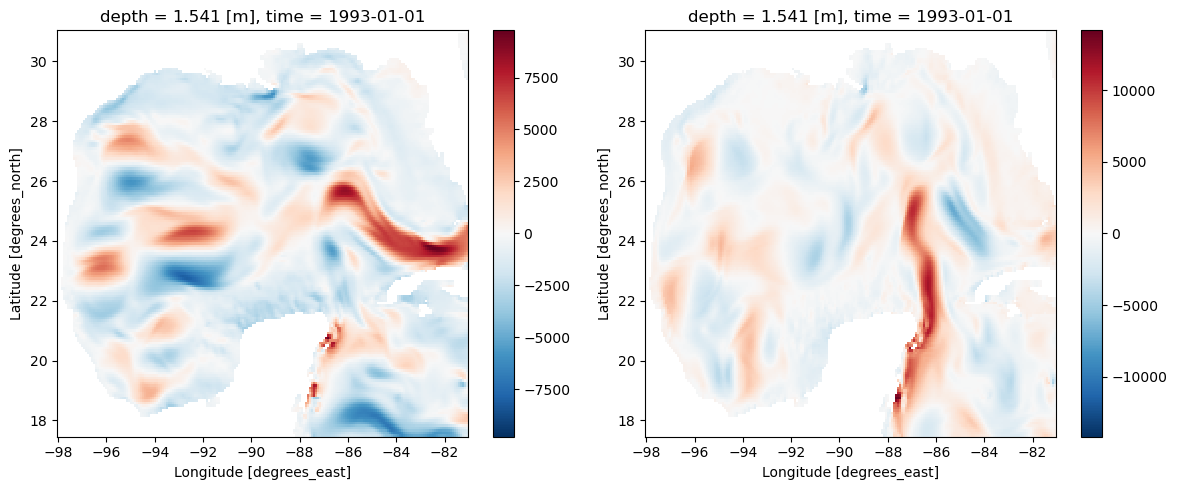

In [66]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
u_weighted[0,0].plot(ax=ax0)
v_weighted[0,0].plot(ax=ax1)
plt.tight_layout();

In [57]:
amld = ggom.mlotst.mean('time')

mlt = theta_weighted.where(theta_weighted.depth<=amld)
mlu = u_weighted.where(u_weighted.depth<=amld)
mlv = v_weighted.where(v_weighted.depth<=amld)

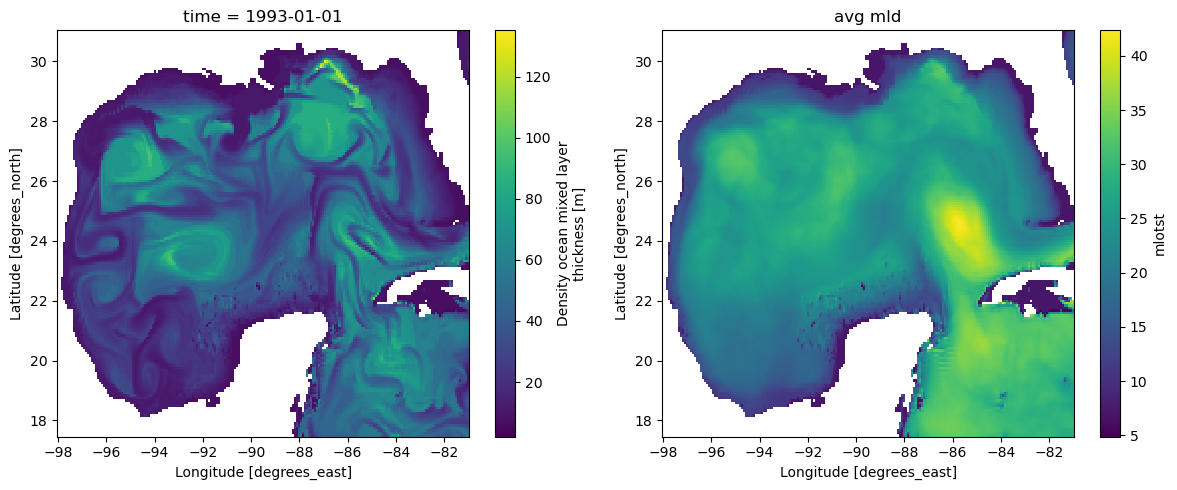

In [24]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
ggom.mlotst[0].plot(ax=ax0)
amld.plot(ax=ax1)
ax1.set_title('avg mld')
plt.tight_layout();

In [27]:
ggom_weighted = xr.merge([theta_weighted.rename('thetao'), u_weighted.rename('uo'), v_weighted.rename('vo')])

In [28]:
ggom_weighted

<xarray.Dataset> Size: 28GB
Dimensions:    (depth: 48, latitude: 163, longitude: 204, time: 730)
Coordinates:
  * depth      (depth) float32 192B 1.541 2.646 3.819 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 9GB dask.array<chunksize=(730, 48, 163, 204), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float64 9GB dask.array<chunksize=(730, 48, 163, 204), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float64 9GB dask.array<chunksize=(730, 48, 163, 204), meta=np.ndarray>

In [29]:
ds_weighted = generate_grid_ds(ggom_weighted, {'X':'longitude', 'Y':'latitude'})
grid_weighted = xgcm.Grid(ds_weighted, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [30]:
grid_weighted

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
Z Axis (not periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time

In [31]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [32]:
cell_elements_weighted = deg_2_m(grid_weighted, ds_weighted, 'latitude', 'longitude')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


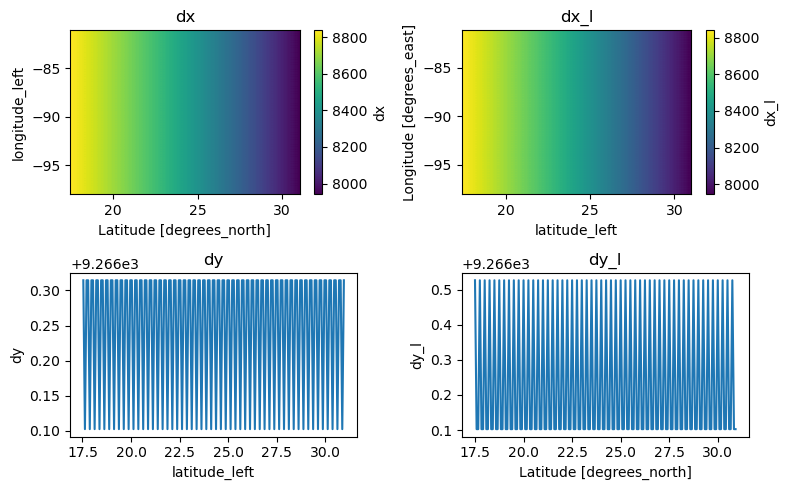

In [33]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_weighted.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_weighted.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_weighted.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_weighted.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [45]:
#unweighted since u/v are weighted already 
dθdx = (grid_pt_full.diff(ggom.thetao, 'X') / cell_elements_glorys.dx)
dθdy = (grid_pt_full.diff(ggom.thetao, 'Y') / cell_elements_glorys.dy) 

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [47]:
dθdx.coords

Coordinates:
  * depth           (depth) float32 196B 0.494 1.541 ... 4.833e+03 5.275e+03
  * latitude        (latitude) float32 652B 17.5 17.58 17.67 ... 30.92 31.0
  * time            (time) datetime64[ns] 6kB 1993-01-01 ... 1994-12-31
  * longitude_left  (longitude_left) float32 820B -98.04 -97.96 ... -81.04

In [48]:
dθdy.coords

Coordinates:
  * depth          (depth) float32 196B 0.494 1.541 ... 4.833e+03 5.275e+03
  * longitude      (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time           (time) datetime64[ns] 6kB 1993-01-01 ... 1994-12-31
  * latitude_left  (latitude_left) float32 652B 17.46 17.54 ... 30.88 30.96

In [49]:
dθdx_interp = grid_pt_full.interp(dθdx, 'X')
dθdy_interp = grid_pt_full.interp(dθdy, 'Y')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [50]:
dθdx_interp

<xarray.DataArray (time: 730, depth: 49, latitude: 163, longitude: 205)> Size: 10GB
dask.array<transpose, shape=(730, 49, 163, 205), dtype=float64, chunksize=(730, 49, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

In [51]:
dθdy_interp

<xarray.DataArray (time: 730, depth: 49, latitude: 163, longitude: 205)> Size: 10GB
dask.array<transpose, shape=(730, 49, 163, 205), dtype=float64, chunksize=(730, 49, 163, 205), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

In [54]:
udθdx = ggom_weighted.uo * dθdx_interp.isel(depth=slice(1,None), longitude=slice(None,-1))
vdθdy = ggom_weighted.vo * dθdy_interp.isel(depth=slice(1,None), longitude=slice(None,-1))

In [58]:
amld.isel(longitude=slice(None, -1)).coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08

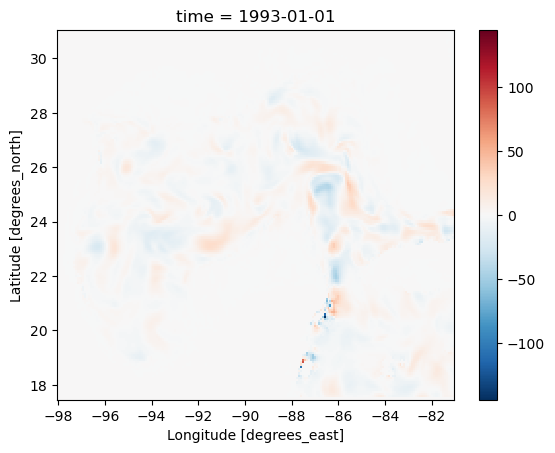

In [56]:
(udθdx + vdθdy).sum('depth')[0].plot()

In [59]:
(udθdx + vdθdy).sum('depth').coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

In [60]:
amld.isel(longitude=slice(None, -1)).coords

Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08

In [61]:
second_term = -(1 / amld.isel(longitude=slice(None, -1))) * (udθdx + vdθdy).sum('depth')

In [62]:
second_term

<xarray.DataArray (latitude: 163, longitude: 204, time: 730)> Size: 194MB
dask.array<mul, shape=(163, 204, 730), dtype=float64, chunksize=(163, 204, 730), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 816B -98.0 -97.92 -97.83 ... -81.17 -81.08
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31

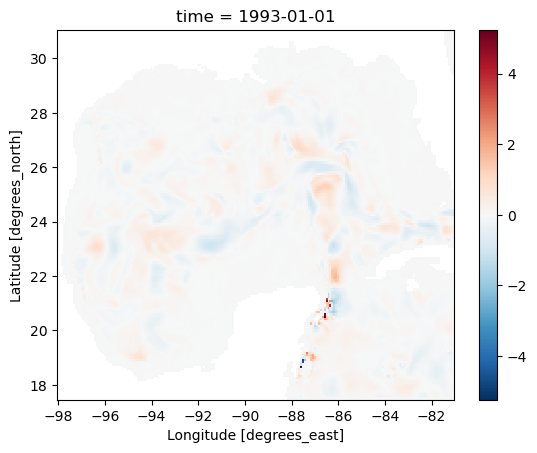

In [63]:
second_term.isel(time=0).plot()

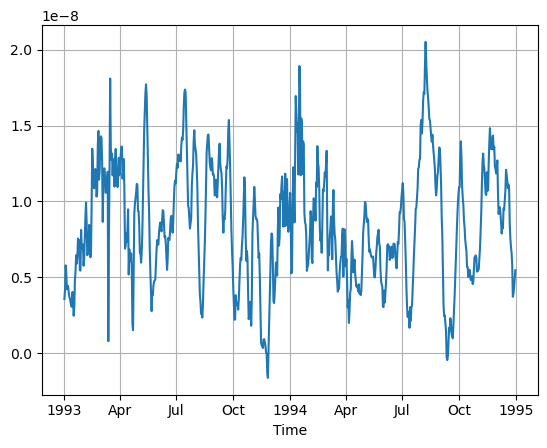

In [64]:
(second_term.mean(['latitude', 'longitude'])/1e6).plot()
plt.grid();

In [65]:
second_term.rename('advection').to_netcdf('/work5/stb/MHW-gfdl/MLHB-terms/adv.nc')

## 2c) $\frac{Q}{\rho C_p H} $

### Create grid and area objects

In [12]:
ds_full_e = generate_grid_ds(heat_fluxes, {'X':'longitude', 'Y':'latitude'})
#ds_full_m = generate_grid_ds(merra, {'X':'lon', 'Y':'lat'})

grid_e = xgcm.Grid(ds_full_e, periodic='X')
#grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [13]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [14]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'latitude', 'longitude')
#cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


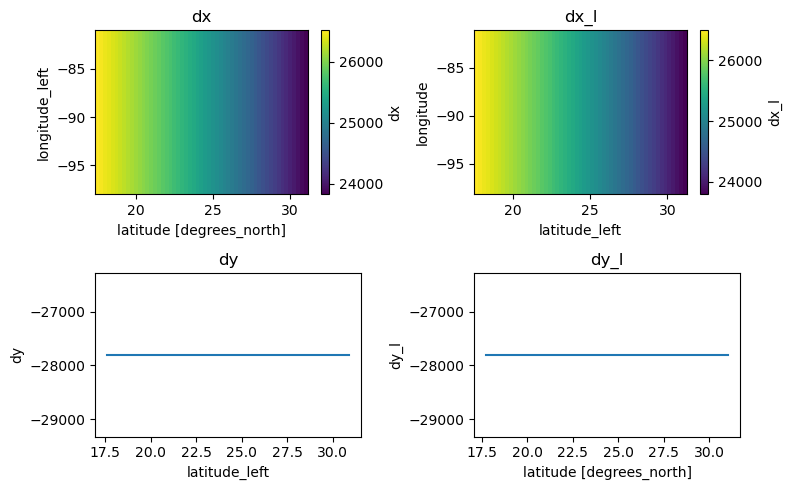

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [16]:
mask_e = sst[0].isnull()
#mask_m = merra.TSKINWTR[0].isnull()

In [17]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

#dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
#area_m = dx_interp_m * cell_elements_m.dy_l

/nbhome/Shanice.Bailey/conda/envs/bai/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [18]:
area_e

<xarray.DataArray (longitude: 69, latitude: 55)> Size: 15kB
array([[-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       ...,
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [-6.6239117e+08, -6.6412147e+08, -6.6583917e+08, ...,
        -7.3494573e+08, -7.3598067e+08,            nan],
       [ 4.5042598e+10,  4.5160260e+10,  4.5277061e+10, ...,
         4.9976308e+10,  5.0046685e+10,            nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

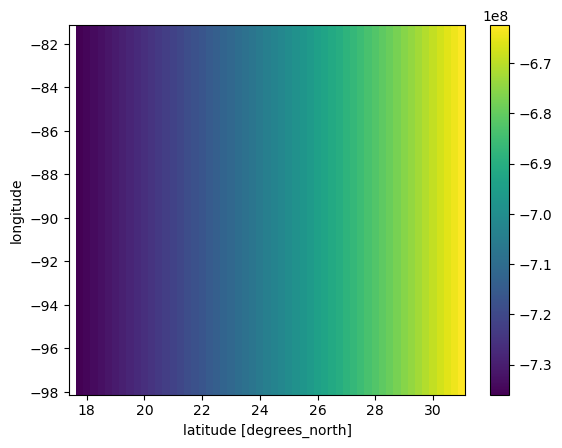

In [19]:
area_e.isel(longitude=slice(None, -1)).plot()

In [20]:
area_e.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

In [22]:
heat_fluxes.coords

Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

In [52]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)
amld = ggom.mlotst.mean('time')

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted_unmasked = (heat_fluxes.isel(longitude=slice(None, -1)) * 
                         area_e.isel(longitude=slice(None, -1)) * (1/Cp) * (1/rho) * (1/amld)) #˚C m^3/s
era_weighted = era_weighted_unmasked.where(~mask_e)
#merra_weighted = (merra.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                 # area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

In [53]:
era_weighted

<xarray.Dataset> Size: 87MB
Dimensions:    (time: 730, latitude: 55, longitude: 68)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25
Data variables:
    ssr        (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>
    str        (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>

$$F_{PS77} = Re^{- \frac{z}{h_1}} + (1-R)e^{- \frac{z}{h_2}}$$
where $R = 0.58$, $h_1 = 0.35$ m, $h_2 = 0.23$ m (eq from Groeskamp and Iudicone 2018 GRL)

In [54]:
ggom.depth.values

array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03], dtype=float32)

In [46]:
#Create decay function for SSR penetration
#Jerlov Type 1 (upper 50m)
R = 0.68
h1 = 1.2 #m
h2 = 28 #m
z_values = np.array([0, 4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03])
z = xr.DataArray(data=z_values, dims={'depth'}, coords={'depth':z_values})
F_ps77 = R * np.exp(-z/h1) + (1-R) * np.exp(-z/h2)

#expand ssr da in z dimension then apply decay function 
ssr_Zexpanded = heat_fluxes.ssr.expand_dims({'depth':z}) 
ssr_z = ssr_Zexpanded * (F_ps77)

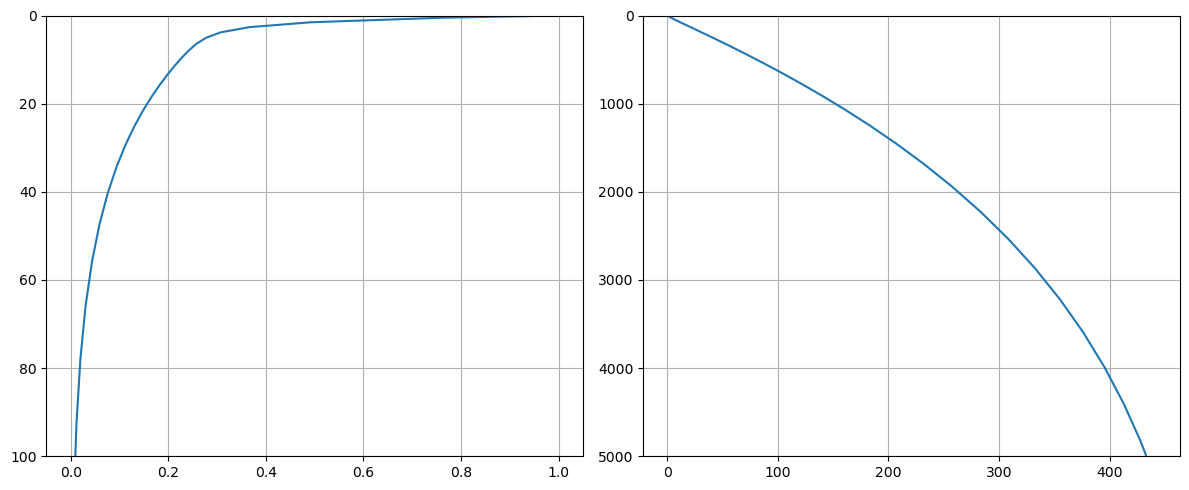

In [47]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(F_ps77, z)
ax0.set_ylim(100, 0)
ax0.grid()

ax1.plot(z.diff(dim='depth'), z.diff(dim='depth').depth)
ax1.set_ylim(5000,0)
#ax1.set_xlim(0, None)
ax1.grid()

plt.tight_layout();

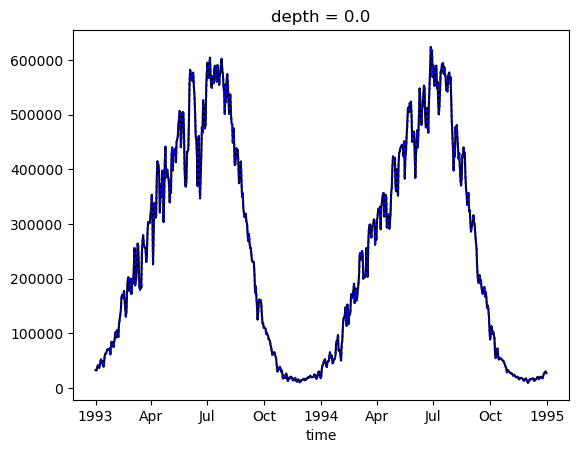

In [48]:
heat_fluxes.ssr.sum(['latitude', 'longitude']).plot(color='k')
ssr_z.sum(['latitude', 'longitude']).isel(depth=0).plot(color='blue', linestyle='dotted')

In [49]:
dFlx = ssr_z.diff(dim='depth')
dz = z.diff(dim='depth')
dFlxdz = - dFlx / dz

In [50]:
dFlxdz

<xarray.DataArray (depth: 49, time: 730, latitude: 55, longitude: 69)> Size: 1GB
dask.array<truediv, shape=(49, 730, 55, 69), dtype=float64, chunksize=(49, 730, 55, 69), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0

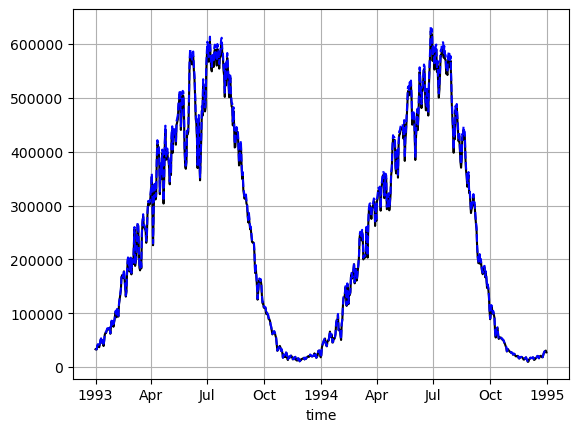

In [51]:
heat_fluxes.ssr.sum(['latitude', 'longitude']).plot(color='k')
dFlxdz.sum(['latitude', 'longitude', 'depth']).plot(color='blue', linestyle='--')
plt.grid()

In [54]:
heat_fluxes['ssr_z'] = dFlxdz

In [55]:
heat_fluxes

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 730, longitude: 69, depth: 49)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Data variables:
    ssr        (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    str        (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    ssr_z      (depth, time, latitude, longitude) float64 1GB dask.array<chunksize=(49, 730, 55, 69), meta=np.ndarray>

In [61]:
era_weighted.drop_vars('ssr')

<xarray.Dataset> Size: 66MB
Dimensions:    (time: 730, latitude: 55, longitude: 68)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 272B -98.0 -97.75 -97.5 ... -81.5 -81.25
Data variables:
    str        (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>
    slhf       (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 68), meta=np.ndarray>

In [56]:
Q = heat_fluxes.drop_vars('ssr').to_array().sum('variable')

In [57]:
Q

<xarray.DataArray (time: 730, latitude: 55, longitude: 69, depth: 49)> Size: 1GB
dask.array<sum-aggregate, shape=(730, 55, 69, 49), dtype=float64, chunksize=(730, 55, 69, 49), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03

In [94]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027
sw = heat_fluxes.ssr_z * (1 / rho) * (1 / Cp) * (1 / amld)
lw = heat_fluxes.str * (1 / rho) * (1 / Cp) * (1 / amld)
sh = heat_fluxes.sshf * (1 / rho) * (1 / Cp) * (1 / amld)
lh = heat_fluxes.slhf * (1 / rho) * (1 / Cp) * (1 / amld)

third_term = xr.merge([sw.rename('sw'), lw.rename('lw'), sh.rename('sh'), lh.rename('lh')])

In [95]:
third_term

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 55, time: 730, longitude: 69, depth: 49)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 6kB 1993-01-01 1993-01-02 ... 1994-12-31
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Data variables:
    sw         (depth, time, latitude, longitude) float64 1GB dask.array<chunksize=(49, 730, 55, 69), meta=np.ndarray>
    lw         (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    sh         (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>
    lh         (time, latitude, longitude) float64 22MB dask.array<chunksize=(730, 55, 69), meta=np.ndarray>

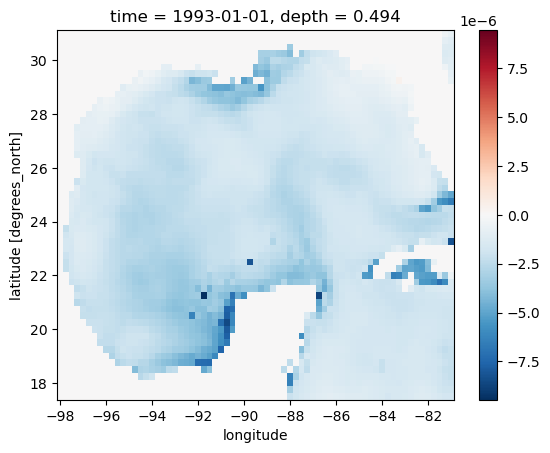

In [96]:
third_term.to_array().sum('variable')[0,0].plot()

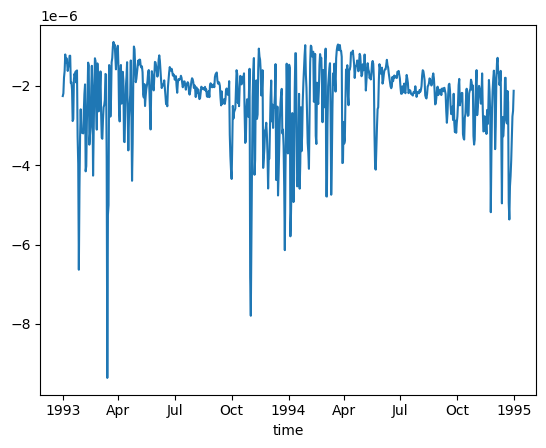

In [97]:
third_term.mean(['depth', 'longitude', 'latitude']).to_array().sum('variable').plot()

In [99]:
third_term.to_netcdf('/work5/stb/MHW-gfdl/MLHB-terms/surf_fluxes_unweighted.nc')

# 3) Compute budget!

$$ \frac{\partial \theta}{\partial t} =  -\frac{1}{H}\int^{0}_{-H}(\mathbf{u} \cdot \nabla_{h}\theta)dz + \frac{Q}{\rho C_p H} + residual$$

- 1st term: temperature tendency
- 2nd term: vertical integral of the product between the depth-dependent $\mathbf{u}$ and the horizontal gradient of the mixed layer temperature T
- 3rd term: air-sea heat flux Q, where ρ is the average seawater density, Cp is the specific heat capacity of seawater (4000 J kg−1 °C−1), H is the mixed layer depth
- 4th term: the residual includes horizontal eddy heat fluxes and the heat flux at the bottom of the mixed layer owing to radiative heat loss, vertical diffusion, entrainment, and vertical advection
([Amaya 2020](https://www.nature.com/articles/s41467-019-10206-z))

In [81]:
dTdt = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/dTdt_9321_unweighted_mld.nc')
adv = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/adv_9321_unweighted_mld.nc')
hf = xr.open_dataset('/work5/stb/MHW-gfdl/MLHB-terms/surf_fluxes_9321_unweighted_mld.nc')

In [82]:
hf

<xarray.Dataset> Size: 16GB
Dimensions:    (latitude: 55, time: 10408, longitude: 69, depth: 49)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * depth      (depth) float64 392B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
Data variables:
    sw         (depth, time, latitude, longitude) float64 15GB ...
    lw         (time, latitude, longitude) float64 316MB ...
    sh         (time, latitude, longitude) float64 316MB ...
    lh         (time, latitude, longitude) float64 316MB ...

In [83]:
dTdt

<xarray.Dataset> Size: 8GB
Dimensions:    (depth: 3, latitude: 163, longitude: 205, time: 10407)
Coordinates:
  * depth      (depth) float32 12B 0.494 1.541 2.646
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30
Data variables:
    tendency   (time, depth, latitude, longitude) float64 8GB ...

In [84]:
adv#.advection.isel(time=slice(1,None))

<xarray.Dataset> Size: 3GB
Dimensions:    (latitude: 163, longitude: 205, time: 10408)
Coordinates:
  * latitude   (latitude) float32 652B 17.5 17.58 17.67 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 820B -98.0 -97.92 -97.83 ... -81.08 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    advection  (time, latitude, longitude) float64 3GB ...

In [85]:
residual = (dTdt.tendency.sum('depth') + 
            adv.advection.isel(time=slice(1,None)) - 
            hf.to_array().sum('variable').isel(time=slice(1,None)).sum('depth'))

In [86]:
residual

<xarray.DataArray (time: 10407, latitude: 55, longitude: 69)> Size: 316MB
array([[[           nan,            nan,            nan, ...,
         3.96449531e-05, 5.56316732e-05, 4.31513928e-05],
        [           nan,            nan,            nan, ...,
         3.76845797e-05, 3.45673610e-05, 3.96911269e-05],
        [           nan,            nan,            nan, ...,
         8.88929859e-05, 9.41170993e-05, 8.51314531e-05],
        ...,
        [           nan,            nan,            nan, ...,
                    nan, 1.52091333e-04, 1.11451714e-04],
        [           nan,            nan,            nan, ...,
                    nan, 1.32848752e-04, 1.00962723e-04],
        [           nan,            nan,            nan, ...,
                    nan, 1.28731146e-04, 1.03649651e-04]],

       [[           nan,            nan,            nan, ...,
         4.84656133e-05, 7.57463796e-05, 5.78576758e-05],
        [           nan,            nan,            nan, ...,
         5.15315797e-05, 4.60967215e-05, 4.74933641e-05],
        [           nan,            nan,            nan, ...,
         1.08503247e-04, 1.17704933e-04, 1.11921184e-04],
...
        [           nan,            nan,            nan, ...,
                    nan, 1.30584172e-04, 1.61418502e-04],
        [           nan,            nan,            nan, ...,
                    nan, 1.80813636e-04, 1.67373182e-04],
        [           nan,            nan,            nan, ...,
                    nan, 2.43887083e-04, 2.21920231e-04]],

       [[           nan,            nan,            nan, ...,
         6.65494279e-05, 6.78551077e-05, 7.29046733e-05],
        [           nan,            nan,            nan, ...,
         6.65319597e-05, 6.82141658e-05, 6.61887036e-05],
        [           nan,            nan,            nan, ...,
         6.88018819e-05, 6.55695443e-05, 7.32750391e-05],
        ...,
        [           nan,            nan,            nan, ...,
                    nan, 1.06015318e-04, 1.34012377e-04],
        [           nan,            nan,            nan, ...,
                    nan, 1.23989508e-04, 1.06557031e-04],
        [           nan,            nan,            nan, ...,
                    nan, 1.38918827e-04, 1.03735161e-04]]])
Coordinates:
  * latitude   (latitude) float32 220B 17.5 17.75 18.0 18.25 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 276B -98.0 -97.75 -97.5 ... -81.25 -81.0
  * time       (time) datetime64[ns] 83kB 1993-01-02 1993-01-03 ... 2021-06-30

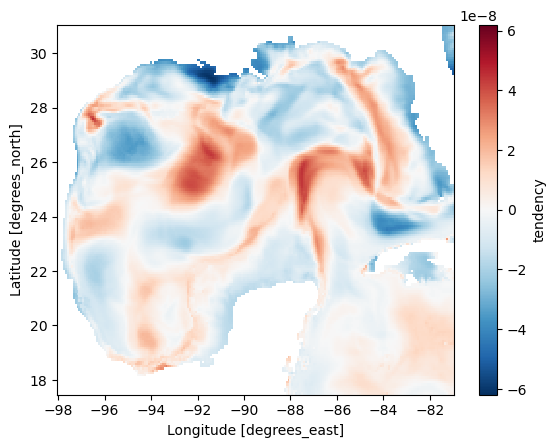

In [26]:
dTdt.tendency.mean(('time', 'depth')).plot()

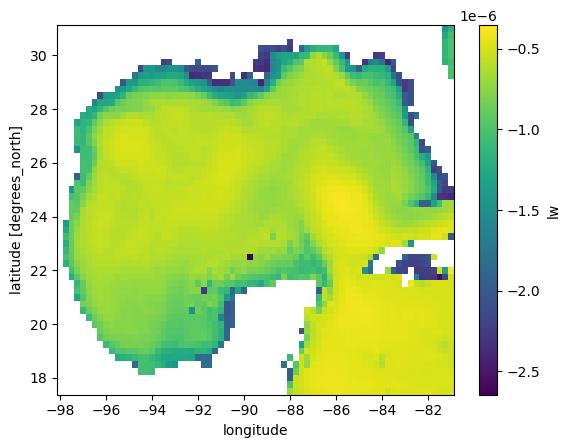

In [29]:
hf.lw.mean(('time')).plot()

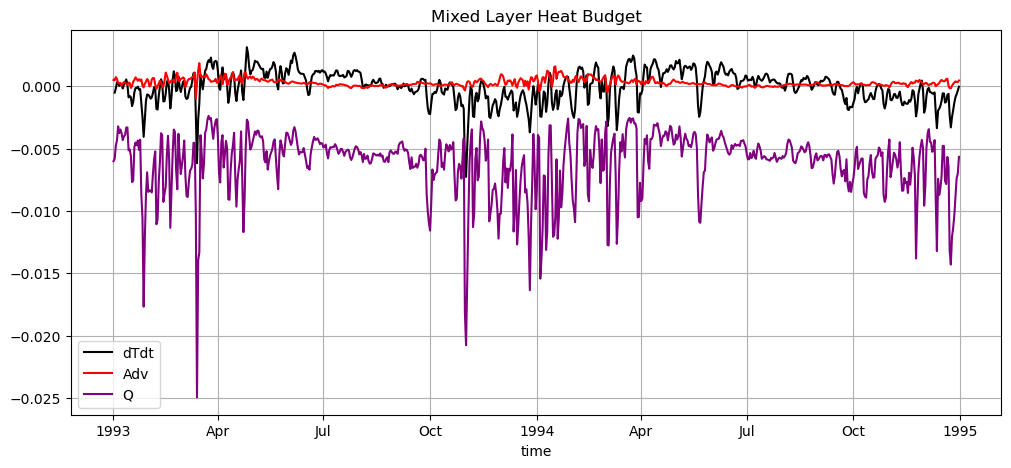

In [23]:
plt.figure(figsize=(12,5))
(dTdt.tendency*3650).isel(longitude=-15,).plot(color='k', label='dTdt')
(adv.advection*3650).plot(color='r', label='Adv')
(hf*3650).to_array().sum('variable').mean(['latitude','longitude', 'depth']).plot(color='purple', label='Q')
#residual.mean(['latitude','longitude']).plot(color='grey', linestyle='dashed', label='R')
plt.legend()
plt.grid()
plt.title('Mixed Layer Heat Budget');

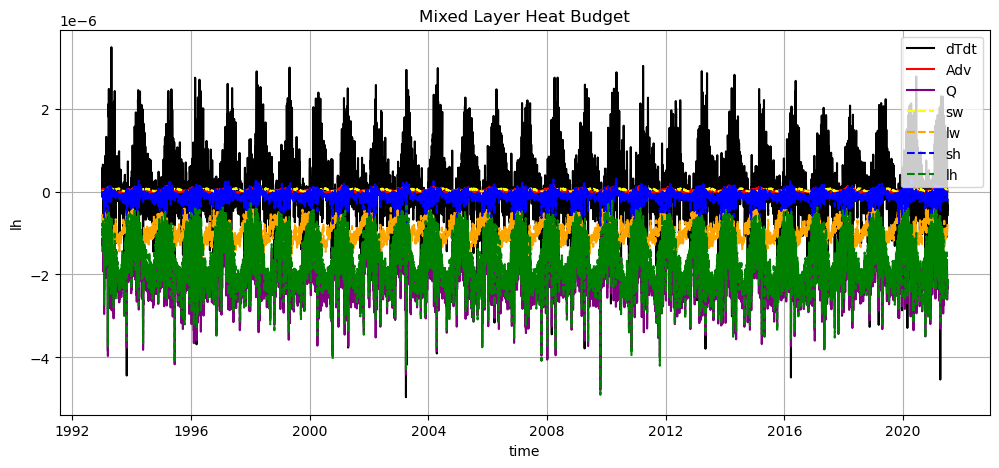

In [87]:
plt.figure(figsize=(12,5))
dTdt.tendency.mean(['latitude','longitude', 'depth']).plot(color='k', label='dTdt')
adv.advection.mean(['latitude','longitude']).plot(color='r', label='Adv')
hf.to_array().sum('variable').mean(['latitude','longitude', 'depth']).plot(color='purple', label='Q')
hf.sw.mean(['latitude','longitude', 'depth']).plot(color='yellow', label='sw', linestyle='dashed')
hf.lw.mean(['latitude','longitude']).plot(color='orange', label='lw', linestyle='dashed')
hf.sh.mean(['latitude','longitude']).plot(color='blue', label='sh', linestyle='dashed')
hf.lh.mean(['latitude','longitude']).plot(color='green', label='lh', linestyle='dashed')
#residual.mean(['latitude','longitude']).plot(color='grey', linestyle='dashed', label='R')
plt.legend()
plt.grid()
plt.title('Mixed Layer Heat Budget');

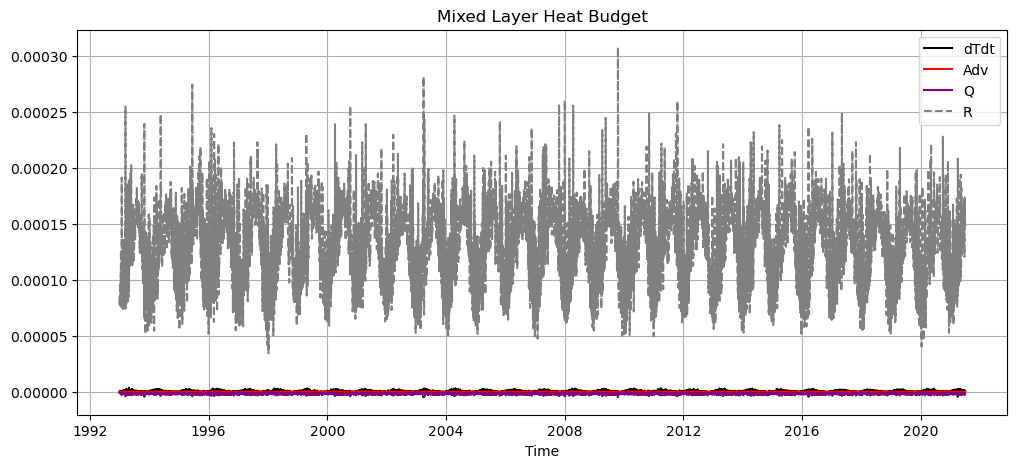

In [89]:
plt.figure(figsize=(12,5))
dTdt.tendency.mean(['latitude','longitude', 'depth']).plot(color='k', label='dTdt')
adv.advection.mean(['latitude','longitude']).plot(color='r', label='Adv')
hf.to_array().sum('variable').mean(['latitude','longitude', 'depth']).plot(color='purple', label='Q')
#hf.sw.mean(['latitude','longitude', 'depth']).plot(color='yellow', label='sw', linestyle='dashed')
#hf.lw.mean(['latitude','longitude']).plot(color='orange', label='lw', linestyle='dashed')
#hf.sh.mean(['latitude','longitude']).plot(color='blue', label='sh', linestyle='dashed')
#hf.lh.mean(['latitude','longitude']).plot(color='green', label='lh', linestyle='dashed')
residual.mean(['latitude','longitude']).plot(color='grey', linestyle='dashed', label='R')
plt.legend()
plt.grid()
plt.title('Mixed Layer Heat Budget');

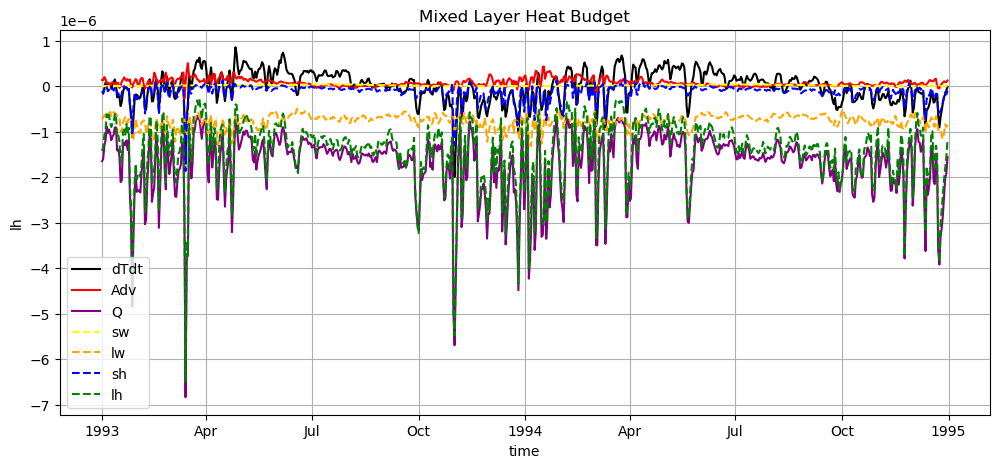

In [21]:
plt.figure(figsize=(12,5))
dTdt.tendency.mean(['latitude','longitude', 'depth']).plot(color='k', label='dTdt')
adv.advection.mean(['latitude','longitude']).plot(color='r', label='Adv')
hf.to_array().sum('variable').mean(['latitude','longitude', 'depth']).plot(color='purple', label='Q')
hf.sw.mean(['latitude','longitude', 'depth']).plot(color='yellow', label='sw', linestyle='dashed')
hf.lw.mean(['latitude','longitude']).plot(color='orange', label='lw', linestyle='dashed')
hf.sh.mean(['latitude','longitude']).plot(color='blue', label='sh', linestyle='dashed')
hf.lh.mean(['latitude','longitude']).plot(color='green', label='lh', linestyle='dashed')
#residual.mean(['latitude','longitude']).plot(color='grey', linestyle='dashed', label='R')
plt.legend()
plt.grid()
plt.title('Mixed Layer Heat Budget');

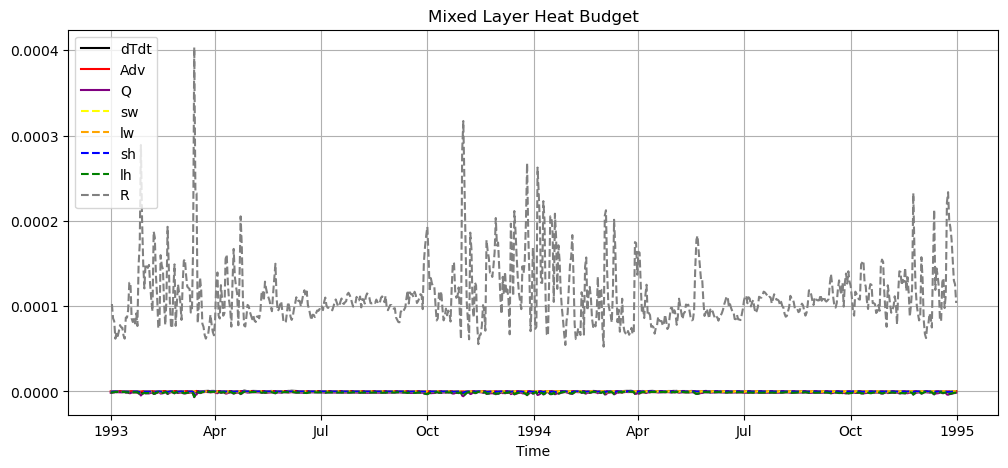

In [22]:
plt.figure(figsize=(12,5))
dTdt.tendency.mean(['latitude','longitude', 'depth']).plot(color='k', label='dTdt')
adv.advection.mean(['latitude','longitude']).plot(color='r', label='Adv')
hf.to_array().sum('variable').mean(['latitude','longitude', 'depth']).plot(color='purple', label='Q')
hf.sw.mean(['latitude','longitude', 'depth']).plot(color='yellow', label='sw', linestyle='dashed')
hf.lw.mean(['latitude','longitude']).plot(color='orange', label='lw', linestyle='dashed')
hf.sh.mean(['latitude','longitude']).plot(color='blue', label='sh', linestyle='dashed')
hf.lh.mean(['latitude','longitude']).plot(color='green', label='lh', linestyle='dashed')
residual.mean(['latitude','longitude']).plot(color='grey', linestyle='dashed', label='R')
plt.legend()
plt.grid()
plt.title('Mixed Layer Heat Budget');